This is a project submitted for the Kaggle competition of laboratory scale earthquake prediction

Link to the project : https://www.kaggle.com/c/LANL-Earthquake-Prediction

Forecasting earthquakes is one of the most important problems in Earth science because of their devastating consequences. Current scientific studies related to earthquake forecasting focus on three key points: when the event will occur, where it will occur, and how large it will be.

In this competition, I am addressing when the earthquake will take place using machine learning. Specifically, I am  predicting the time remaining before laboratory earthquakes occur from real-time seismic data.

This challenge is hosted by Los Alamos National Laboratory which enhances national security by ensuring the safety of the U.S. nuclear stockpile, developing technologies to reduce threats from weapons of mass destruction, and solving problems related to energy, environment, infrastructure, health, and global security concerns.

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import pickle
from scipy import signal

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import xgboost as xgb
import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
import gc
from catboost import CatBoostRegressor
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Input Data and Data Exploration

In [3]:
datapath = os.path.join("datasets", "kaggle_earthquake", "")

#read full training data from csv file
#train = pd.read_csv(datapath + "train.csv", nrows=2000000, skiprows=range(1, 4000000))                                                                     
#pd.read_csv('test.csv', sep='|', skiprows=range(1, 10))


# save resampled training data to pickle
#import pickle
#with open('train_full.pickle', 'wb') as f:
#    pickle.dump(train, f)

#load pickled data of already sampled data
with open(datapath + 'train_full.pickle', 'rb') as f:
    train= pickle.load(f)


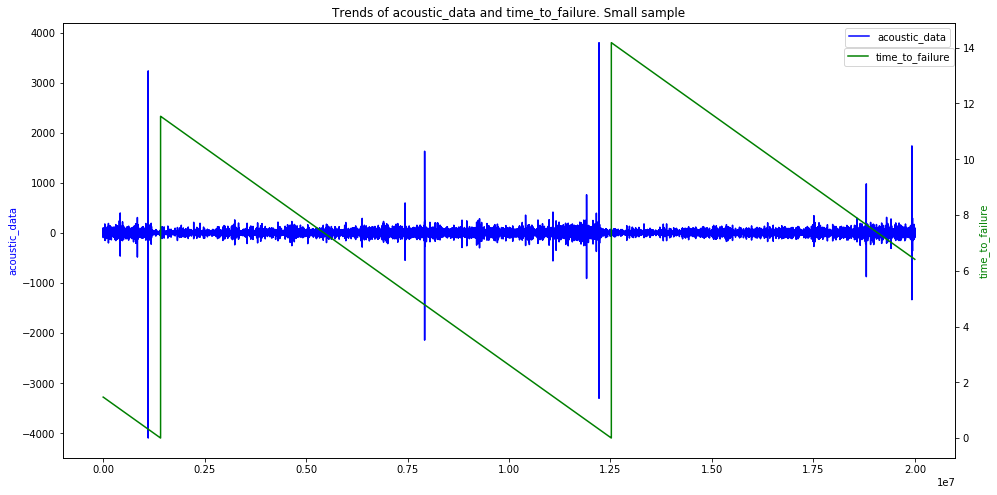

In [10]:
#Plot small sections of data

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. Small sample")
#plt.plot(train['acoustic_data'].values, color='b')
plt.plot(train['acoustic_data'].values[0:20000000], color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
#plt.plot(train['time_to_failure'].values, color='g')
plt.plot(train['time_to_failure'].values[0:20000000], color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

We can see that there is a slight time gap between the earthquake seismic signal and the time of earthquake recorded. We can also see that there are some large amplitude which doesnt large enough to be classified as earthquake but still significanlty have larger amplitude than the the surrounding signal

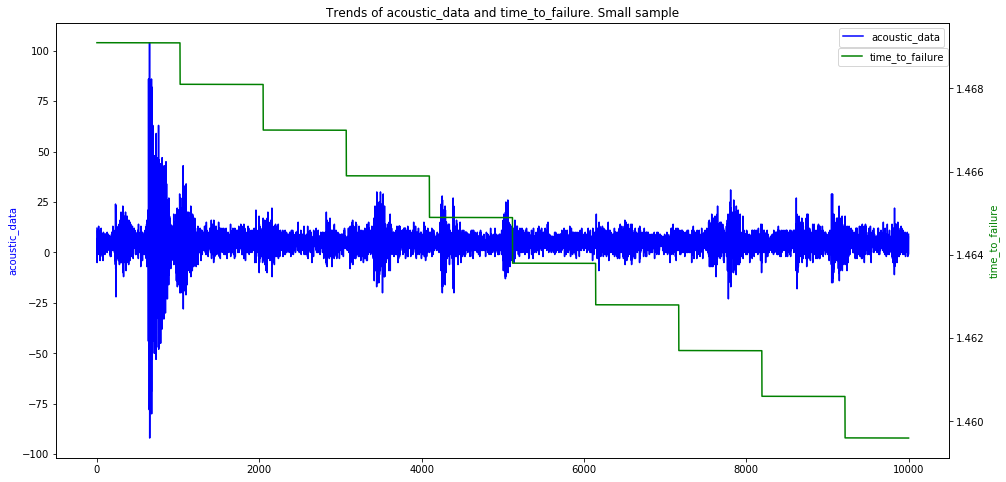

In [13]:
#Plot smaller sections of data

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. Small sample")
#plt.plot(train['acoustic_data'].values, color='b')
plt.plot(train['acoustic_data'].values[0:10000], color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
#plt.plot(train['time_to_failure'].values, color='g')
plt.plot(train['time_to_failure'].values[0:10000], color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

In [ ]:

# frequency analysis of non-earthquake

earthquake_idx = train[train.acoustic_data.abs() == train.acoustic_data.abs().max()].index[0] #index where the biggest earthquake happens

data = train.acoustic_data[earthquake_idx-50000:earthquake_idx-10000][::4] # based on frequency nyquist, data can be down-sampled by a quarter
f, P_den = signal.periodogram(data, Fs_inblock_res, nfft=2*len(data)) # frequency spectrum
P_den = pd.Series(P_den).rolling(window=600).mean() # smoothened the spectra density

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title('Acoustic data of non-earthquake (noise)')
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.subplot(2,2,2)
plt.title("Frequency of noise")
plt.plot(f, P_den)
plt.xlabel('Freq (Hz)')
plt.ylabel('PSD')

# frequency of only the earthquake
data = train.acoustic_data[earthquake_idx-10000:earthquake_idx+10000][::4] # based on frequency nyquist, data can be down-sampled by a quarter
f, P_den = signal.periodogram(data, Fs_inblock_res, nfft=2*len(data)) # frequency spectrum
P_den = pd.Series(P_den).rolling(window=300).mean() # smoothened the spectra density

plt.subplot(2,2,3)
plt.title('Acoustic data of earthquake')
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.subplot(2,2,4)
plt.title('Frequency of earthquake')
plt.plot(f, P_den)
plt.xlabel('Freq (Hz)')
plt.ylabel('PSD')
plt.ylim(bottom=0)
plt.xlim(left=0)
show()

earthquake_freq = f[P_den == P_den.max()] # peak frequency of earthquake

del data, f, P_den

# conclusions: at least for this particular earthquake sample, the peak frequency is difference with the noise.
# other difference is the PSD amplitude.

Text(0, 0.5, 'power')

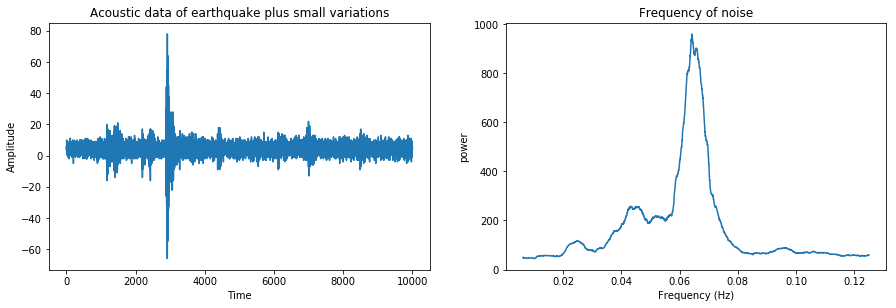

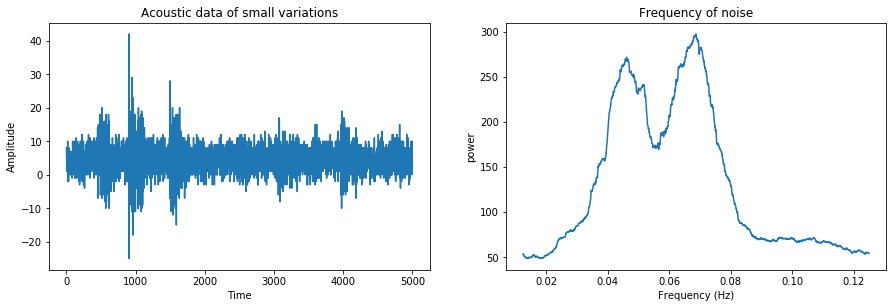

In [35]:
#dt_resampled = train.time_to_failure[0]-train.time_to_failure[4] # dt within block. 1 block: 4095 samples
#fs = 1/dt_resampled # sampling rate within a block after resampled

fs = 1/4

# Now we try to see the difference in frequency spectrum in the time
#when there is no earthquake and in the time when there is an earthquake

max_earthquake_idx = train[train.acoustic_data.abs() == train.acoustic_data.abs().max()].index[0] #index where the biggest earthquake happens

#Frequency Spectrum of all frequency of data (earthquake plus small variations)
#fs = 1/4 #sampling rate, input data have been sampled every 4 of index increment, so we only use 1 here 
data = train.acoustic_data.values[max_earthquake_idx-5000:max_earthquake_idx+5000]#[::4] 
f, power = signal.periodogram(data,fs,nfft=2*len(data))
power = pd.Series(power).rolling(window=500).mean()

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title('Acoustic data of earthquake plus small variations')
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.subplot(2,2,2)
plt.title("Frequency of noise")
plt.plot(f, power)
plt.xlabel('Frequency (Hz)')
plt.ylabel('power')

#Frequency Spectrum of just the small variations
fs = 1/4 #sampling rate, input data have been sampled every 4 of index increment, so we only use 1 here 
data = train.acoustic_data.values[max_earthquake_idx-10000:max_earthquake_idx-5000]#[::4] 
f, power = signal.periodogram(data,fs,nfft=2*len(data))
power = pd.Series(power).rolling(window=500).mean()

plt.figure(figsize=(15,10))
plt.subplot(2,2,3)
plt.title('Acoustic data of small variations')
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.subplot(2,2,4)
plt.title("Frequency of noise")
plt.plot(f, power)
plt.xlabel('Frequency (Hz)')
plt.ylabel('power')


We can see the differences in peak frequency of earthquake.

# Feature Engineering

In [36]:
#Split data into several segments, each mimick the length of test data
# original row numbers of test data 150000, because we resmamples the data by 4 the row numbers is 37500

rows = 37500
num_segments = int(len(train)/rows)
num_segments


#Create variable X_tr & Y_tr, which consist of number of segments, each row represent each segments(37500 rows) of training
#data, and Y_tr is time to failure represents time to failure in 

X_tr = pd.DataFrame(index=range(num_segments), dtype=np.float64)
y_tr = pd.DataFrame(index=range(num_segments), dtype=np.float64, columns=['time_to_failure'])

total_mean = train['acoustic_data'].mean()
total_std = train['acoustic_data'].std()
total_max = train['acoustic_data'].max()
total_min = train['acoustic_data'].min()
total_sum = train['acoustic_data'].sum()
total_abs_sum = np.abs(train['acoustic_data']).sum()

for segment in tqdm_notebook(range(num_segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = pd.Series(seg['acoustic_data'].values)
    y = seg['time_to_failure'].values[-1]
    
    y_tr.loc[segment, 'time_to_failure'] = y 
    
    X_tr.loc[segment, 'mean'] = x.mean()
    X_tr.loc[segment, 'std'] = x.std()
    X_tr.loc[segment, 'max'] = x.max()
    X_tr.loc[segment, 'min'] = x.min()
    
    X_tr.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
    X_tr.loc[segment, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    
    X_tr.loc[segment, 'abs_max'] = np.abs(x).max()
    X_tr.loc[segment, 'abs_min'] = np.abs(x).min()
    
    X_tr.loc[segment, 'q95'] = np.quantile(x, 0.95)
    X_tr.loc[segment, 'q99'] = np.quantile(x, 0.99)
    X_tr.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X_tr.loc[segment, 'q01'] = np.quantile(x, 0.01)
    
    X_tr.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_tr.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_tr.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_tr.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
#    X_tr.loc[segment, 'trend'] = add_trend_feature(x)
#    X_tr.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_tr.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_tr.loc[segment, 'abs_std'] = np.abs(x).std()
    
    X_tr.loc[segment, 'mad'] = x.mad()
    X_tr.loc[segment, 'kurt'] = x.kurtosis()
    X_tr.loc[segment, 'skew'] = x.skew()
    X_tr.loc[segment, 'med'] = x.median()
    
    #Frequency based Features
    f_X_tr, P_den_X_tr = signal.periodogram(x, fs, nfft=2*len(x)) # frequency spectrum
    P_den_X_tr = pd.Series(P_den_X_tr).rolling(window=300).mean() # smoothened the spectra density
    
    X_tr.loc[segment, 'peak_freqw'] = np.float64(f_X_tr[P_den_X_tr == P_den_X_tr.max()])/1e5 # down-scaled
    X_tr.loc[segment, 'max_spectw'] = P_den_X_tr.max()*1e9 # up-scaled
    X_tr.loc[segment, 'mean_spectw'] = P_den_X_tr.mean()*1e9 #up-scaled
    
    
#     for windows in [10, 100, 1000]:      
#         x_roll_std = x.rolling(windows).std().dropna().values
#         x_roll_mean = x.rolling(windows).mean().dropna().values

#         X_tr.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
#         X_tr.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
#         X_tr.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
#         X_tr.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
#         X_tr.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
#         X_tr.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
#         X_tr.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
#         X_tr.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
#         X_tr.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
#         X_tr.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
#         X_tr.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()

#         X_tr.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
#         X_tr.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
#         X_tr.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
#         X_tr.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
#         X_tr.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
#         X_tr.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
#         X_tr.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
#         X_tr.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
#         X_tr.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
#         X_tr.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
#         X_tr.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

    
    
    
    
    


In [38]:
X_tr.head()

,mean,std,max,min,mean_change_abs,mean_change_rate,abs_max,abs_min,q95,q99,...,abs_q01,abs_mean,abs_std,mad,kurt,skew,med,peak_freqw,max_spectw,mean_spectw
0,4.890186666666667,5.095142128646708,104.0,-92.0,-0.000160004266780,18710.324829685461737,104.0,0.0,12.0,18.0,...,0.0,5.578080000000000,4.331192725613970,3.262410862933185,34.479491948535269,-0.064429669122700,5.0,0.000000634833333,1.799115807422002e+12,2.083237411271866e+11
1,4.730560000000000,6.596724631746409,181.0,-149.0,0.000053334755593,18722.739003017642972,181.0,0.0,12.0,21.0,...,0.0,5.743520000000000,5.736433461141407,3.571482419200113,102.536169890198792,0.540231611744151,5.0,0.000000648400000,3.189208283462524e+12,3.502009833370944e+11
2,4.917626666666667,6.967086601191905,129.0,-100.0,0.000026667377797,18740.109076203130826,129.0,0.0,13.0,25.0,...,0.0,6.153946666666666,5.903551739569381,3.946831187911372,33.238371055341183,0.225352176089579,5.0,0.000000612466667,3.239766535879771e+12,3.904888526320706e+11
3,4.892480000000000,6.922917315976290,191.0,-199.0,0.000053334755593,18716.753616046840762,199.0,0.0,12.0,22.0,...,0.0,5.932426666666666,6.055506449134680,3.650057574400209,119.896507165917726,0.807473920767449,5.0,0.000000650533333,3.921018512935638e+12,3.855618333498790e+11
4,4.911333333333333,7.324985258219280,145.0,-125.0,-0.000320008533561,18732.731497816468618,145.0,0.0,12.0,26.0,...,0.0,6.116293333333333,6.353519154985918,3.834452657777783,52.998602296020259,0.021277465571198,5.0,0.000000222866667,3.551662554864883e+12,4.319338982638864e+11


In [39]:
# Explore new features, compares with target

np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(20)

q95            0.425076272165485
q05            0.413969846111456
abs_q95        0.348756132232177
mad            0.341639839318008
q99            0.303110176450818
q01            0.302649016262719
abs_mean       0.286916823189557
abs_q99        0.225561275672511
std            0.217090774414275
abs_std        0.201201772685133
min            0.193258656725430
max            0.188396308017959
abs_max        0.187664786152081
kurt           0.109085970978436
mean_spectw    0.105176029614857
max_spectw     0.102592458088930
peak_freqw     0.101868016599466
mean           0.031850635125244
med            0.016634679719394
skew           0.014025280531562
dtype: float64

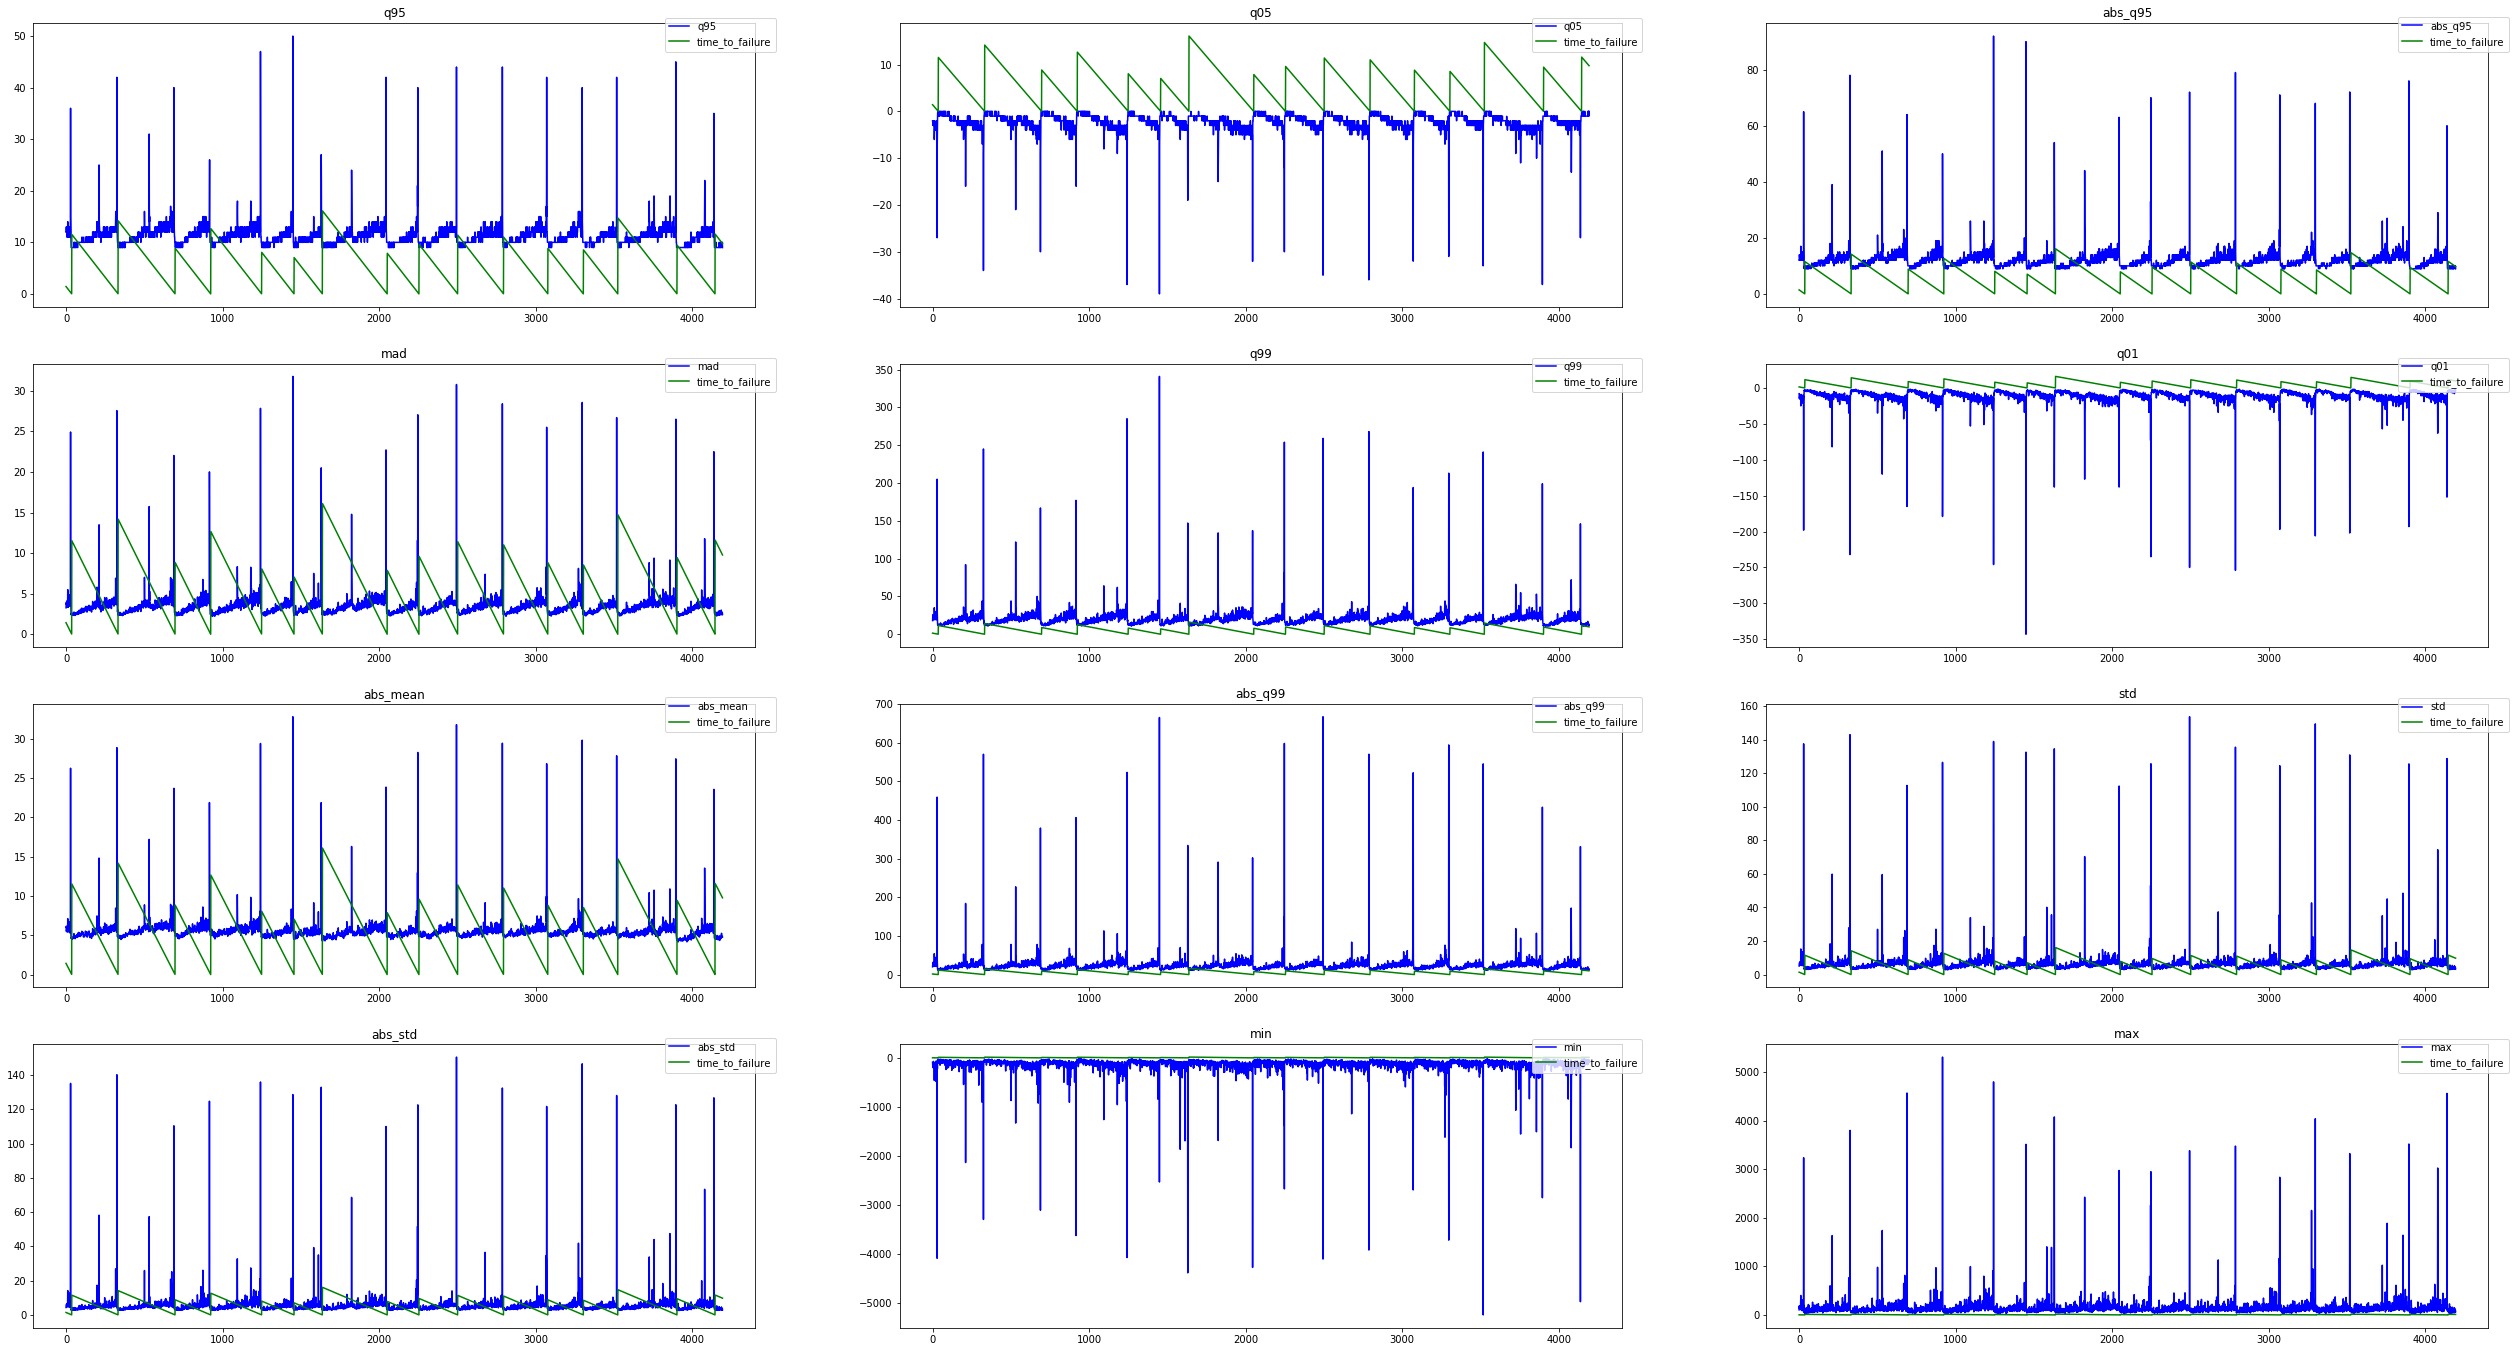

In [40]:
#Plot top 10 correlated features vs target

plt.figure(figsize=(44, 24))
cols = list(np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(12).index)
for i, col in enumerate(cols):
    plt.subplot(4, 3, i + 1)
    plt.plot(X_tr[col], color='blue')
    plt.title(col)
    ax1.set_ylabel(col, color='b')

    ax2 = ax1.twinx()
    plt.plot(y_tr, color='g')
    ax2.set_ylabel('time_to_failure', color='g')
    plt.legend([col, 'time_to_failure'], loc=(0.875, 0.9))
    plt.grid(False)
    


In [41]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_train_scaled = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)

# Input Test Data

In [42]:
# check one file
test = pd.read_csv(datapath + 'test/seg_00a37e.csv',
                    dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
test = test[::4] # resample
print(test.head())
print(test.shape)      

    acoustic_data
0              -2
4               8
8               8
12              2
16              5
(37500, 1)


In [43]:
#Create Features for Test data similar to Our Training Data

submission = pd.read_csv(datapath + 'sample_submission.csv', index_col='seg_id') 
X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)

for i,seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv(datapath + "/test/" + seg_id + ".csv")
    seg = seg[::4]
    
    x = pd.Series(seg['acoustic_data'].values)
#    x = seg.acoustic_data.values
    
    X_test.loc[seg_id, 'mean'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
    
    X_test.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(x))
    X_test.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    
    X_test.loc[seg_id, 'abs_max'] = np.abs(x).max()
    X_test.loc[seg_id, 'abs_min'] = np.abs(x).min()
    
    X_test.loc[seg_id, 'q95'] = np.quantile(x, 0.95)
    X_test.loc[seg_id, 'q99'] = np.quantile(x, 0.99)
    X_test.loc[seg_id, 'q05'] = np.quantile(x, 0.05)
    X_test.loc[seg_id, 'q01'] = np.quantile(x, 0.01)
    
    X_test.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_test.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_test.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_test.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_test.loc[seg_id, 'abs_mean'] = np.abs(x).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(x).std()
    
    X_test.loc[seg_id, 'mad'] = x.mad()
    X_test.loc[seg_id, 'kurt'] = x.kurtosis()
    X_test.loc[seg_id, 'skew'] = x.skew()
    X_test.loc[seg_id, 'med'] = x.median()
    
#    Frequency based Features
    f_X_test, P_den_X_test = signal.periodogram(x, fs, nfft=2*len(x)) # frequency spectrum
    P_den_X_test = pd.Series(P_den_X_test).rolling(window=300).mean() # smoothened the spectra density
    
    X_test.loc[seg_id, 'peak_freqw'] = np.float64(f_X_test[P_den_X_test == P_den_X_test.max()])/1e5 # down-scaled
    X_test.loc[seg_id, 'max_spectw'] = P_den_X_test.max()*1e9 # up-scaled
    X_test.loc[seg_id, 'mean_spectw'] = P_den_X_test.mean()*1e9 #up-scaled
    
    
#     for windows in [10, 100, 1000]:      
#         x_roll_std = x.rolling(windows).std().dropna().values
#         x_roll_mean = x.rolling(windows).mean().dropna().values

#         X_test.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
#         X_test.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
#         X_test.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
#         X_test.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
#         X_test.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
#         X_test.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
#         X_test.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
#         X_test.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
#         X_test.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
#         X_test.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
#         X_test.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()

#         X_test.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
#         X_test.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
#         X_test.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
#         X_test.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
#         X_test.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
#         X_test.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
#         X_test.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
#         X_test.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
#         X_test.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
#         X_test.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
#         X_test.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
        
        
#X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [44]:
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [45]:
X_test.head()

,mean,std,max,min,mean_change_abs,mean_change_rate,abs_max,abs_min,q95,q99,...,abs_q01,abs_mean,abs_std,mad,kurt,skew,med,peak_freqw,max_spectw,mean_spectw
seg_id,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.485546666666667,4.889409160257156,115.0,-75.0,-0.000106669511187,18761.940505226481037,115.0,0.0,11.0,18.0,...,0.0,5.229760000000000,4.083609722482904,3.253514894222201,27.377262063045130,0.275762583305912,4.0,0.000000629533333,9.398458681677158e+11,1.919576155215037e+11
seg_0012b5,4.178560000000000,5.923538245666725,140.0,-140.0,-0.000080002133390,18703.349804262721591,140.0,0.0,11.0,20.0,...,0.0,5.204853333333333,5.045583612380871,3.423587669333354,56.437800216078415,0.308821126541089,4.0,0.000000653133333,1.837987170177180e+12,2.821095931133511e+11
seg_00184e,4.615120000000000,6.944861425179155,241.0,-193.0,-0.000106669511187,18713.666472693414107,241.0,0.0,11.0,20.0,...,0.0,5.601466666666667,6.176870994430608,3.465597166933273,160.050463986336297,0.393269792115263,5.0,0.000000366933333,3.790611879309849e+12,3.879991291705364e+11
seg_003339,4.532906666666666,4.116319836172083,81.0,-81.0,0.000160004266780,18699.275110067508649,81.0,0.0,10.0,14.0,...,0.0,4.968533333333333,3.578393211975317,2.688823011555529,39.430956633272061,0.040992329788630,5.0,0.000000457366667,7.736967262738938e+11,1.358832873588286e+11
seg_0042cc,4.129760000000000,5.794770440559465,177.0,-139.0,-0.000080002133390,18744.867359076270077,177.0,0.0,10.0,19.0,...,0.0,5.071466666666667,4.991420328551134,3.280012014933231,81.965999343668145,0.123127380188689,4.0,0.000000633500000,2.418973998802326e+12,2.698375051317810e+11


# Model Building

In [46]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

def train_model(X=X_train_scaled, X_test=X_test_scaled, y=y_tr, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_tr.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_tr.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
            
        if model_type == 'rcv':
            model = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_absolute_error', cv=3)
            model.fit(X_train, y_train)
            print(model.alpha_)

            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

In [47]:
# model prediction XGBoost 
xgb_params = {'eta': 0.05, 'max_depth': 10, 'subsample': 0.9, #'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'mae', 'silent': True, 'nthread': 4}
oof_xgb, prediction_xgb = train_model(params=xgb_params, model_type='xgb')

Fold 0 started at Thu Jan 24 00:24:03 2019
[0]	train-mae:4.94166	valid_data-mae:5.08646
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[60]	train-mae:0.891545	valid_data-mae:2.23453

Fold 1 started at Thu Jan 24 00:24:10 2019
[0]	train-mae:4.96771	valid_data-mae:4.98206
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[62]	train-mae:0.881194	valid_data-mae:2.16957

Fold 2 started at Thu Jan 24 00:24:17 2019
[0]	train-mae:4.95946	valid_data-mae:5.00805
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[60]	train-mae:0.86826	valid_data-mae:2.21469

Fold 3 started at Thu Jan 24 00:24:24 2019
[0]	train-

In [49]:
def mae(prediction, actual):
    mae=[]
    prediction = pd.DataFrame(prediction)
    for i in range(len(actual)):
        mae.append(abs(prediction.iloc[i][0]-actual.iloc[i]['time_to_failure']))
    return pd.DataFrame(mae).sum()/len(actual)

MAE: 2.1507499706990822 sec


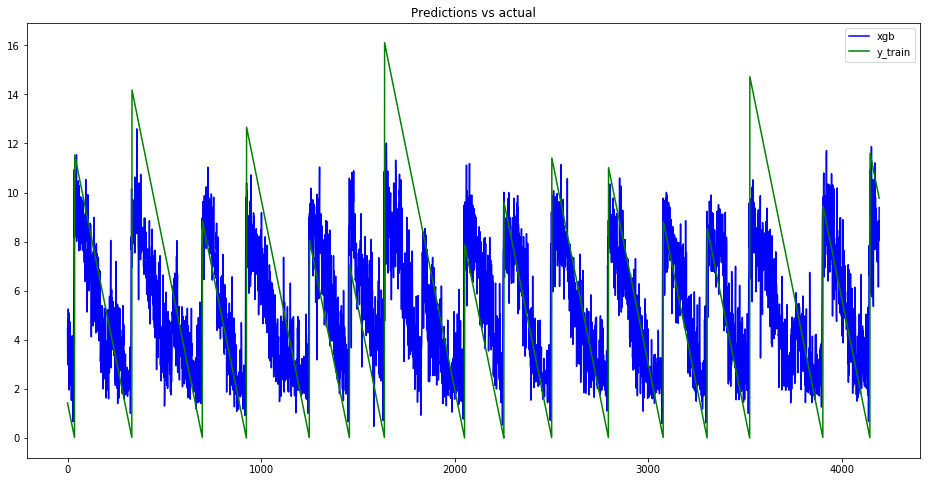

In [51]:
# prediction vs actual
plt.figure(figsize=(16, 8))

plt.plot(oof_xgb, color='blue', label='xgb')
plt.plot(y_tr, color='g', label='y_train')
plt.legend();
plt.title('Predictions vs actual');

error = mae(oof_xgb, y_tr)[0]
print('MAE:', error, 'sec')

In [52]:
submission = pd.read_csv(datapath + 'sample_submission.csv', index_col='seg_id') 
#prediction_xgb = prediction_xgb[0:(len(prediction_xgb))]
submission['time_to_failure'] = (prediction_xgb)
print(submission.head())
submission.to_csv('submission.csv')

              time_to_failure
seg_id                       
seg_00030f  5.056399917602539
seg_0012b5  5.343698215484619
seg_00184e  5.083957767486572
seg_003339  7.109198570251465
seg_0042cc  6.279921150207519


Kaggle Score is 1.529